In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d as spline

import TwoPUtils as tpu

%matplotlib inline

In [2]:
rng = np.random.default_rng()



In [3]:
class KWTA():
    
    def __init__(self,n_pos = 30, w_max=100, n_ca3=1000, n_ca1 = 1000, n_winners = 100, 
                 eta=1E-4, tau=1E-5, eta_ctrl = None, max_pos = 10, ca3_sigma_mag = .15,
                weight_dist='lognormal', w_sigma_mag = 1E-3,w_norm_decay=1E-3):
        
        self.n_pos = n_pos
        self.pos = np.linspace(0,10,num=n_pos)[np.newaxis,:]
        self.max_pos = max_pos
        self.w_max = w_max
        self.n_ca3 = n_ca3
        self.n_ca1 = n_ca1
        self.n_winners = n_winners
        self.eta = eta
        self.tau = tau
        self.ca3_sigma_mag = ca3_sigma_mag
        self.w_sigma_mag = w_sigma_mag
        self.w_norm_decay = w_norm_decay
        
        
        self.mu = np.linspace(0,self.max_pos,num=n_ca3)[:,np.newaxis]
        self.ca3  = tpu.utilities.gaussian(self.mu,.5,self.pos) # cells by postions
        
        if weight_dist == 'uniform':
            self.w = rng.random(size=[n_ca1,n_ca3]) #
        elif weight_dist == 'lognormal':
            self.w = rng.lognormal(sigma=.5, size= [n_ca1,n_ca3])
        else:
            pass
        
        if eta_ctrl is not None:
            ctrl_x = np.linspace(0,10,num=np.array(eta_ctrl).shape[0])
            self.eta_gain = spline(ctrl_x,eta_ctrl)
            self.eta_gain_mat = np.eye(n_pos)*self.eta_gain(self.pos).T
        else:
            self.eta_gain_mat = np.eye(n_pos)
            
        
    
    def winners(self):
        ca1 = np.zeros([self.n_ca1,self.n_pos])
        activations = np.matmul(self.w,self.ca3+self.ca3_sigma_mag*rng.standard_normal(size=[self.n_ca3,self.n_pos])) 
        winners = np.argsort(activations,axis=0)[::-1,:]
        for pos_ind in range(self.n_pos):
            ca1[winners[:self.n_winners,pos_ind],pos_ind]=activations[winners[:self.n_winners,pos_ind],pos_ind]
        return ca1
        
    def forward(self):
#         ca1 = np.zeros([self.n_ca1,self.n_pos])
#         activations = np.matmul(self.w,self.ca3)
#         winners = np.argsort(activations,axis=0)[::-1,:]
#         for pos_ind in range(self.n_pos):(
#             ca1[winners[:self.n_winners,pos_ind],pos_ind]=activations[winners[:self.n_winners,pos_ind],pos_ind]
        ca1 = self.winners()
        self.w += self.eta*np.matmul(np.matmul(ca1,self.eta_gain_mat),self.ca3.T) - self.tau + self.w_sigma_mag*rng.standard_normal(size=self.w.shape)
        self.w -= self.w_norm_decay*np.linalg.norm(self.w,axis=-1,keepdims=True)
        self.w = np.minimum(np.maximum(self.w,0),self.w_max)
        return ca1
    
    def oja(self):
        
        ca1 = self.winners()
        self.w += self.eta*(np.matmul(np.matmul(ca1,self.eta_gain_mat),self.ca3.T) - np.matmul(np.power(ca1,2),self.ca3.T))
        self.w = np.minimum(np.maximum(self.w,0),self.w_max)
        return ca1

(100, 1000, 30)

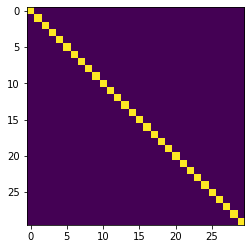

In [4]:
# no learning

nl_kwta = KWTA(eta = 0, tau=0,w_norm_decay=0)
fig,ax = plt.subplots()
ax.imshow(nl_kwta.eta_gain_mat)
nl_ca1 = []
for trial in range(100):
    nl_ca1.append(nl_kwta.forward())
nl_ca1 = np.array(nl_ca1)
nl_ca1.shape

In [5]:
nl_extm = sp.signal.argrelmax(nl_ca1.mean(axis=0),axis=-1)

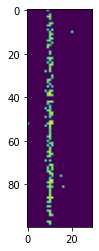

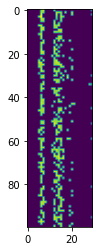

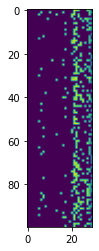

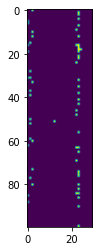

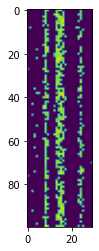

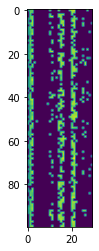

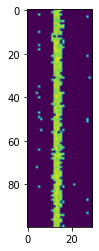

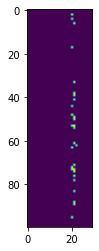

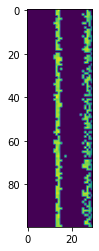

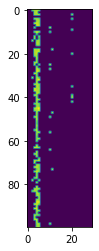

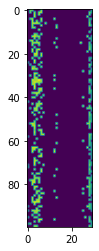

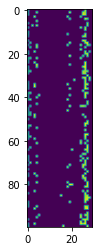

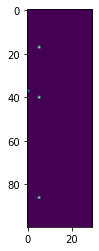

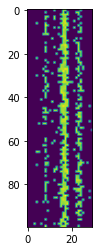

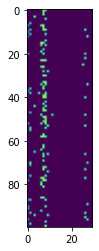

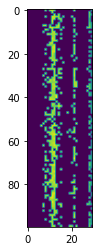

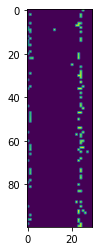

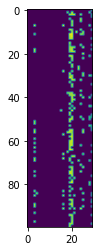

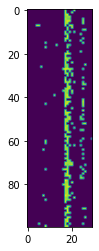

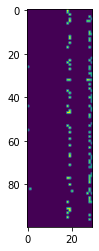

In [6]:
#rate map for a cell

for i in range(20):
    fig, ax = plt.subplots()
    ax.imshow(nl_ca1[:,i,:])

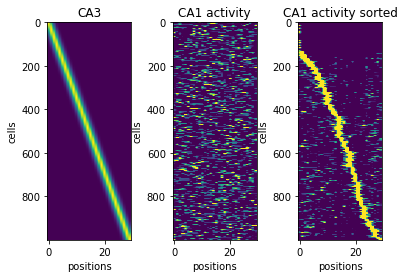

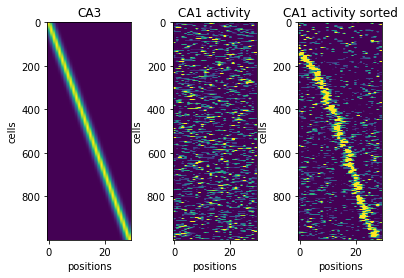

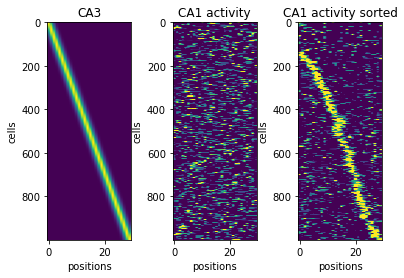

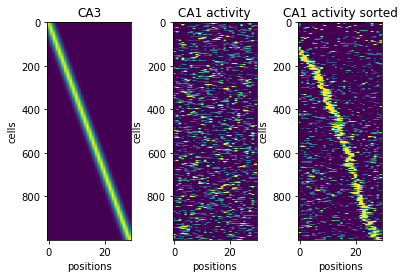

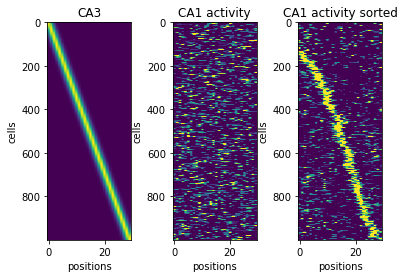

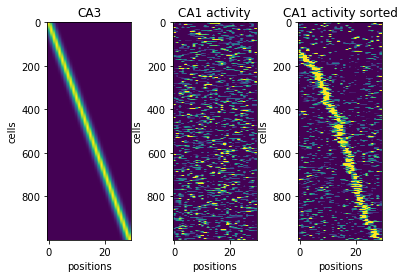

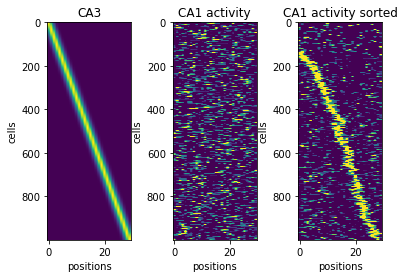

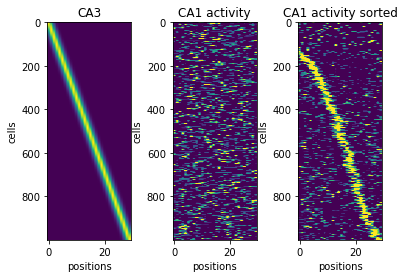

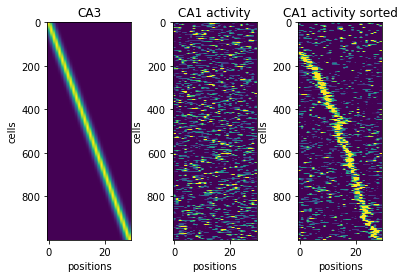

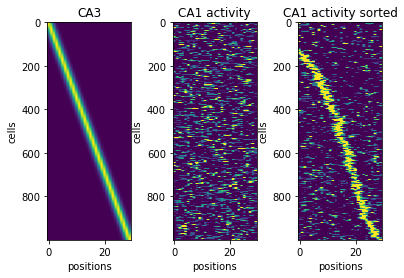

In [7]:

for trial in range(0,10):
    fig,ax = plt.subplots(1,3)
    fig.subplots_adjust(wspace= .5)
    nl_ca1_z = (nl_ca1-nl_ca1.mean(axis=-1,keepdims=True))/(np.std(nl_ca1,axis=-1,keepdims=True)+1E-3)
    ax[0].imshow(nl_kwta.ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(nl_ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')
    
    if trial == 0:
        ca1_sort = np.argsort(np.argmax(nl_ca1[trial,:,:],axis=-1))
    ax[2].imshow(nl_ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    for i in range(3):
        ax[i].set_ylabel('cells')
        ax[i].set_xlabel('positions')


(100, 1000, 30)

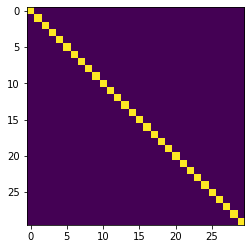

In [8]:
l_kwta = KWTA(eta = 1E-3, tau=0, w_norm_decay=1E-3)
fig,ax = plt.subplots()
ax.imshow(l_kwta.eta_gain_mat)
l_ca1 = []
for trial in range(100):
    l_ca1.append(l_kwta.forward())
#     l_ca1.append(l_kwta.oja())
l_ca1 = np.array(l_ca1)
l_ca1.shape

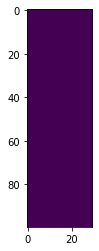

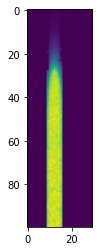

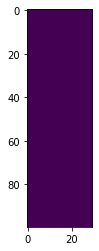

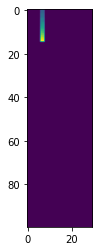

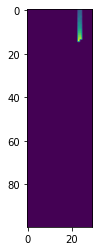

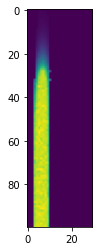

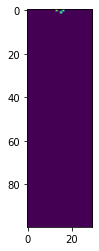

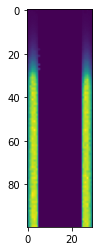

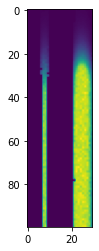

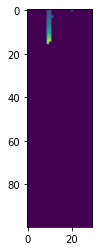

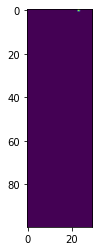

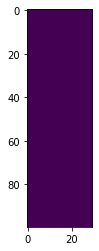

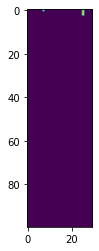

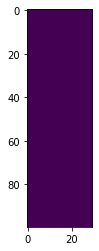

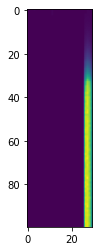

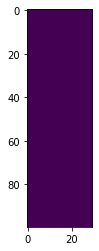

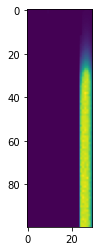

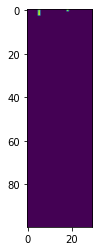

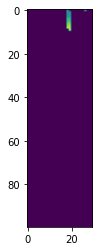

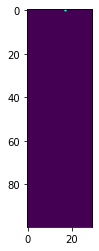

In [9]:
for i in range(20):
    fig, ax = plt.subplots()
    ax.imshow(l_ca1[:,i,:])

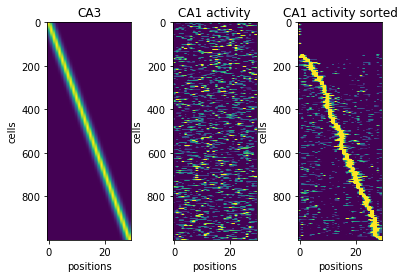

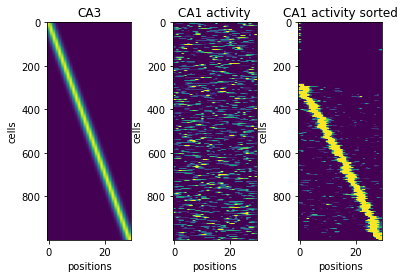

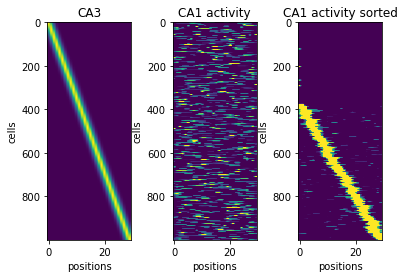

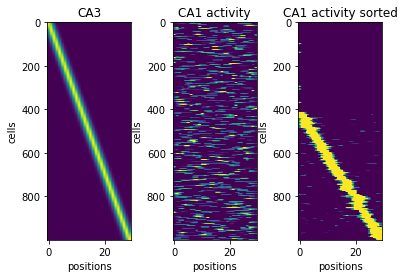

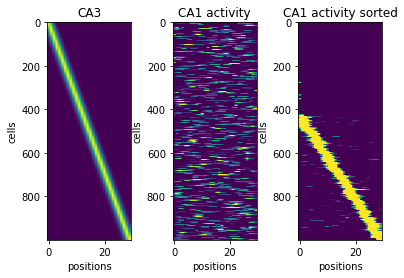

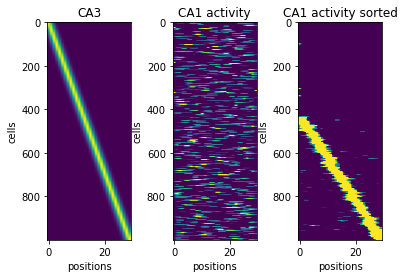

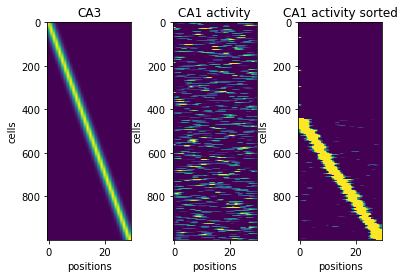

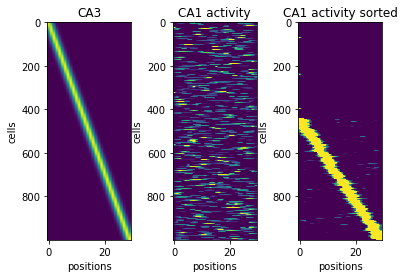

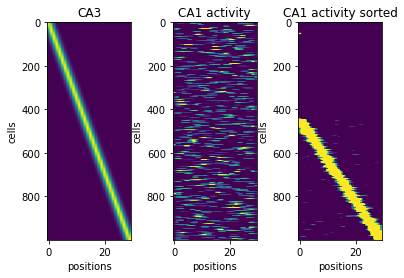

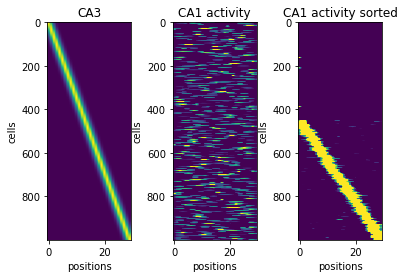

In [10]:
for trial in range(0,10):
    fig,ax = plt.subplots(1,3)
    fig.subplots_adjust(wspace= .5)
    l_ca1_z = (l_ca1-l_ca1.mean(axis=-1,keepdims=True))/(np.std(l_ca1,axis=-1,keepdims=True)+1E-3)
    ax[0].imshow(l_kwta.ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(l_ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')
    
#     if trial == 0:
    ca1_sort = np.argsort(np.argmax(l_ca1[trial,:,:],axis=-1))
    ax[2].imshow(l_ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    for i in range(3):
        ax[i].set_ylabel('cells')
        ax[i].set_xlabel('positions')


(20, 1000, 30)

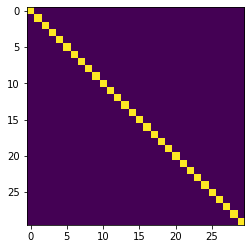

In [11]:
da_kwta = KWTA(eta = 1E-2, tau=0,w_norm_decay=1E-3, eta_ctrl = [.1, .1, .1, .3, .5, .2, .1, .1, .1 ,.1])
fig,ax = plt.subplots()
ax.imshow(l_kwta.eta_gain_mat)
da_ca1 = []
for trial in range(20):
    da_ca1.append(da_kwta.forward())
da_ca1 = np.array(da_ca1)
da_ca1.shape

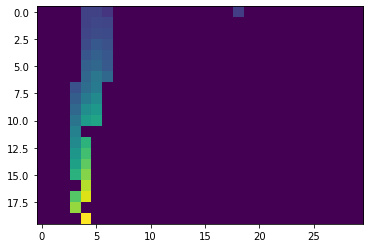

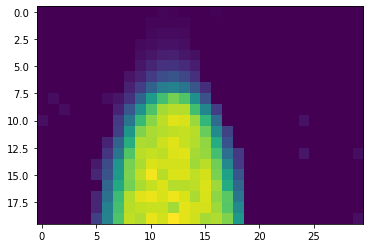

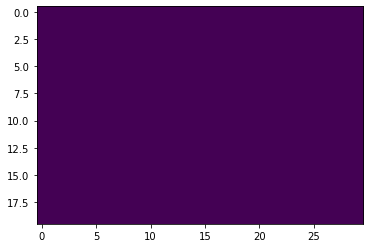

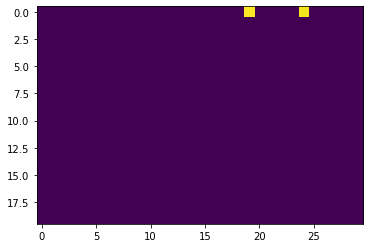

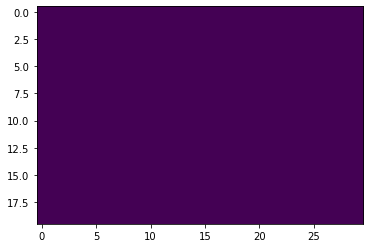

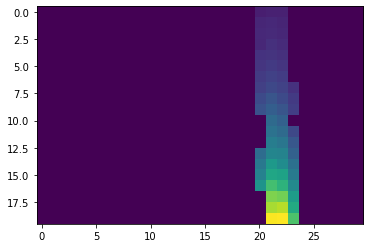

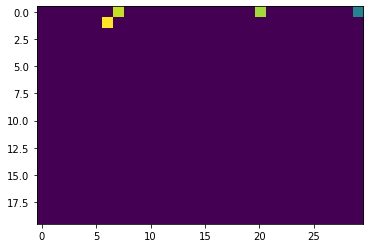

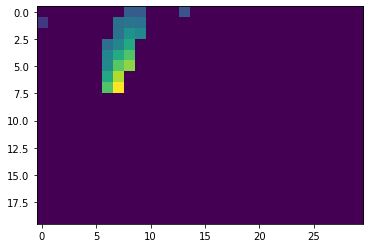

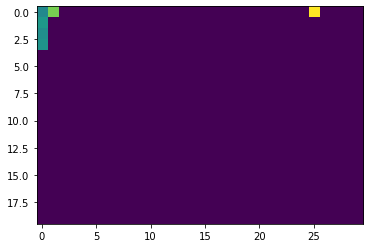

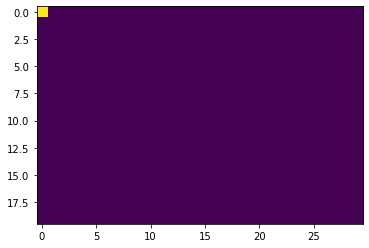

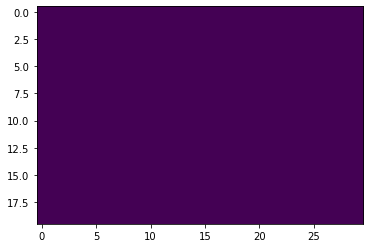

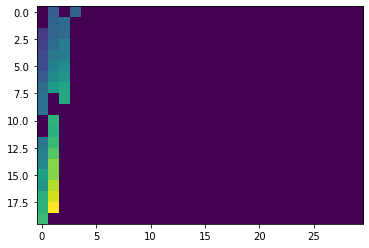

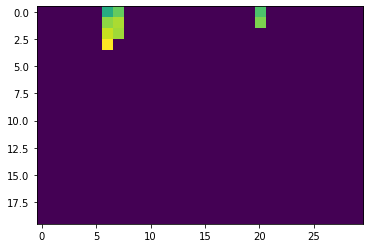

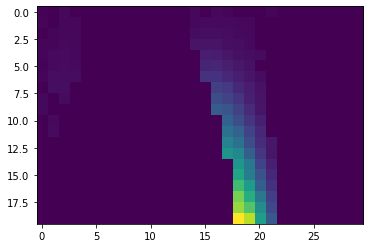

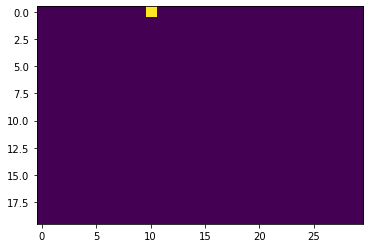

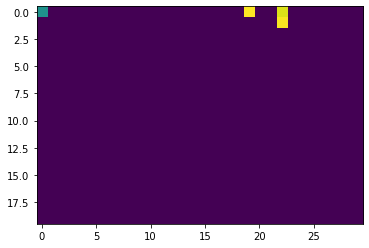

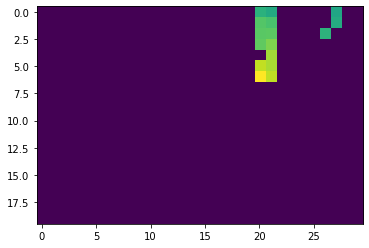

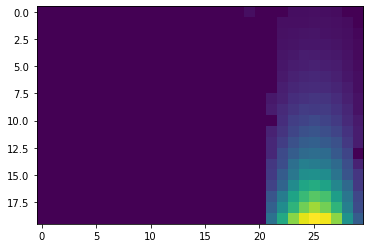

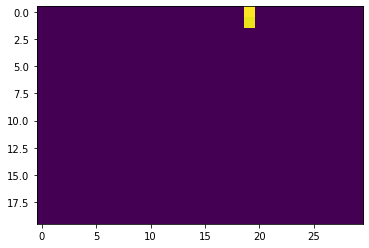

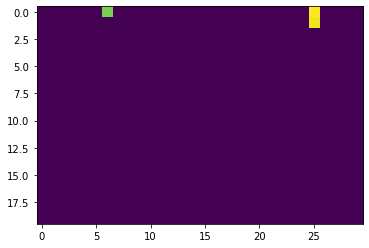

In [12]:
for i in range(20):
    fig, ax = plt.subplots()
    ax.imshow(da_ca1[:,i,:])

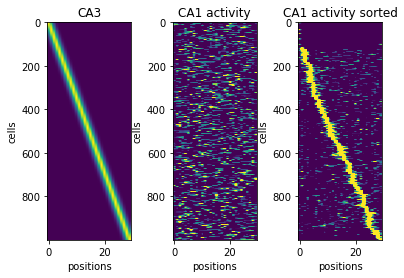

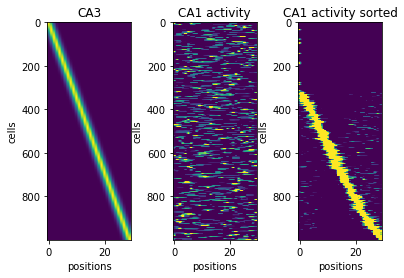

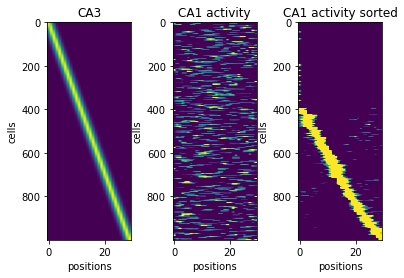

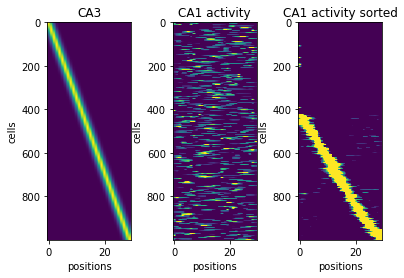

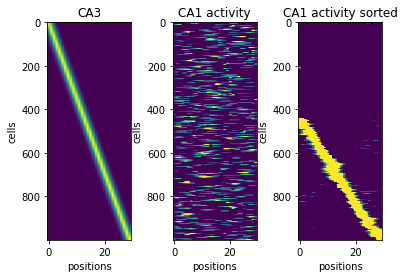

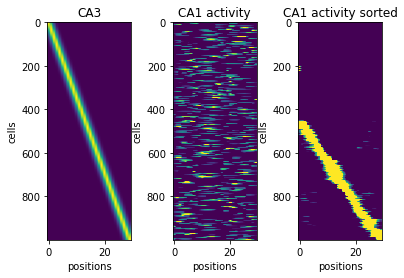

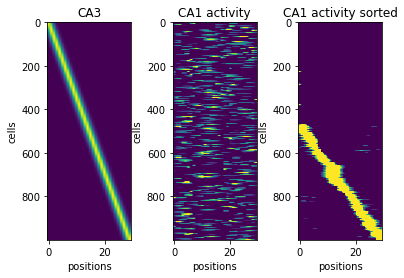

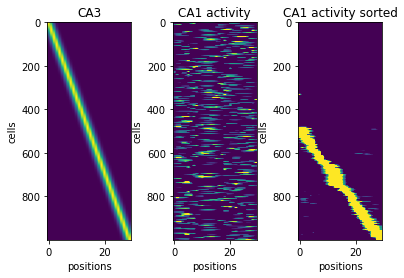

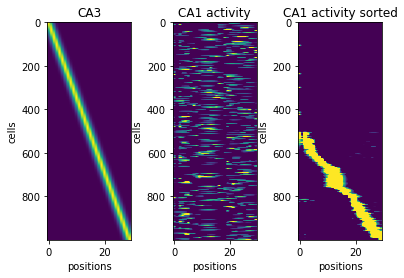

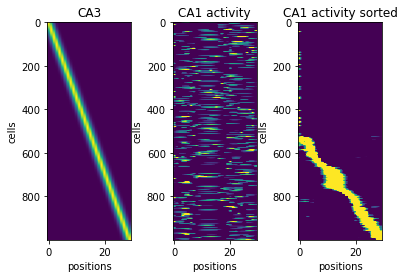

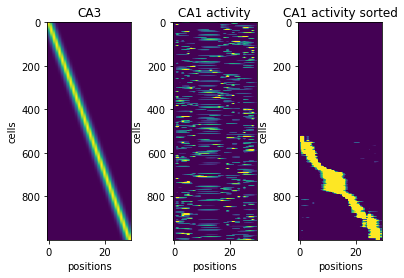

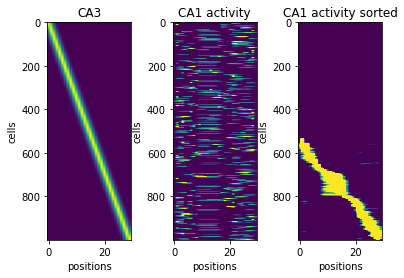

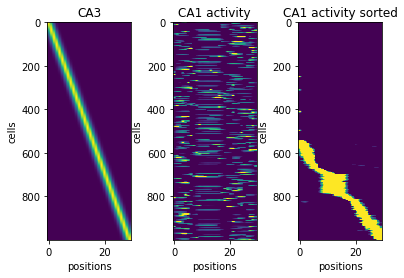

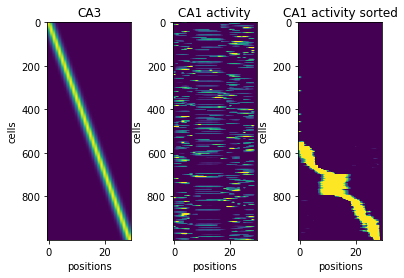

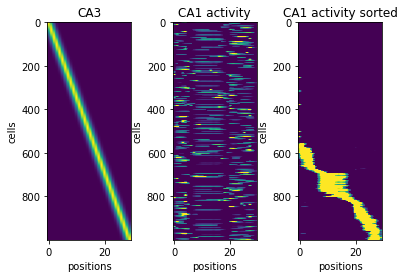

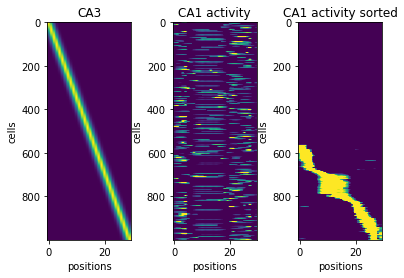

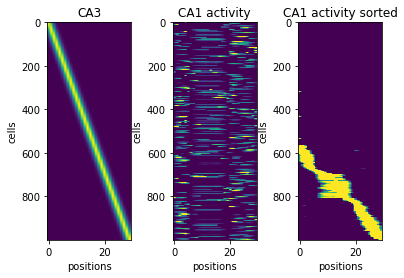

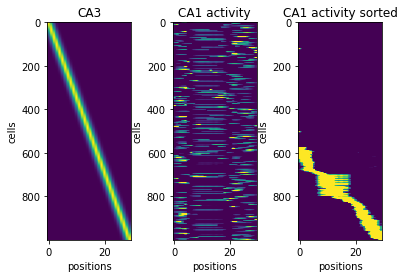

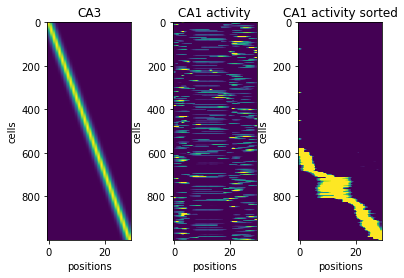

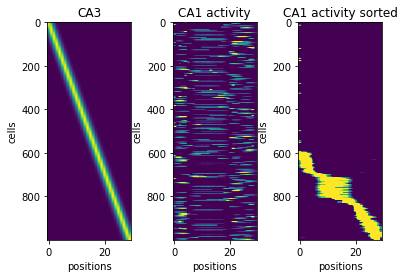

In [13]:
for trial in range(0,20):
    fig,ax = plt.subplots(1,3)
    fig.subplots_adjust(wspace= .5)
    da_ca1_z = (da_ca1-da_ca1.mean(axis=-1,keepdims=True))/(np.std(da_ca1,axis=-1,keepdims=True)+1E-3)
    ax[0].imshow(da_kwta.ca3, vmin=0,vmax=1, aspect='auto')
    ax[0].set_title('CA3')

    ax[1].imshow(da_ca1_z[trial,:,:], vmin=0,vmax=1, aspect='auto')
    
#     if trial == 0:
    ca1_sort = np.argsort(np.argmax(da_ca1[trial,:,:],axis=-1))
    ax[2].imshow(da_ca1_z[trial, ca1_sort,:], vmin=0,vmax=1,aspect='auto')

    ax[1].set_title('CA1 activity')
    ax[2].set_title('CA1 activity sorted')

    for i in range(3):
        ax[i].set_ylabel('cells')
        ax[i].set_xlabel('positions')


In [14]:
nl_prob = nl_ca1.mean(axis=0)/(nl_ca1.mean(axis=0).sum(axis=-1,keepdims=True)+1E-5)
nl_com = (nl_prob*nl_kwta.pos).sum(axis=-1,keepdims=True)
nl_std = (np.power(nl_kwta.pos-nl_com,2)*nl_prob).sum(axis=-1)

l_prob = l_ca1.mean(axis=0)/(l_ca1.mean(axis=0).sum(axis=-1,keepdims=True)+1E-5)
l_com = (l_prob*nl_kwta.pos).sum(axis=-1,keepdims=True)
l_std = (np.power(nl_kwta.pos-l_com,2)*l_prob).sum(axis=-1)
print(nl_kwta.pos)

[[ 0.          0.34482759  0.68965517  1.03448276  1.37931034  1.72413793
   2.06896552  2.4137931   2.75862069  3.10344828  3.44827586  3.79310345
   4.13793103  4.48275862  4.82758621  5.17241379  5.51724138  5.86206897
   6.20689655  6.55172414  6.89655172  7.24137931  7.5862069   7.93103448
   8.27586207  8.62068966  8.96551724  9.31034483  9.65517241 10.        ]]


(array([0.18269231, 0.32692308, 0.47115385, 0.50961538, 0.56730769,
        0.58653846, 0.65384615, 0.69230769, 0.72115385, 0.75961538,
        0.78846154, 0.78846154, 0.82692308, 0.86538462, 0.89423077,
        0.92307692, 0.94230769, 0.98076923, 1.        ]),
 array([1.        , 1.15789474, 1.31578947, 1.47368421, 1.63157895,
        1.78947368, 1.94736842, 2.10526316, 2.26315789, 2.42105263,
        2.57894737, 2.73684211, 2.89473684, 3.05263158, 3.21052632,
        3.36842105, 3.52631579, 3.68421053, 3.84210526, 4.        ]),
 <BarContainer object of 19 artists>)

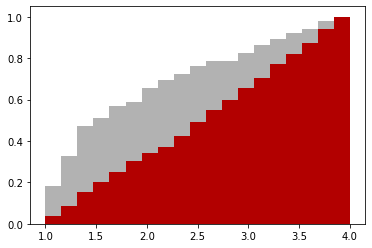

In [16]:
# nl_std = np.std(nl_ca1.mean(axis=0),axis=-1)
# l_std = np.std(l_ca1.mean(axis=0),axis=-1)
bins = np.linspace(1,4,num=20)
fig,ax = plt.subplots()
ax.hist(nl_std,fill=True,bins=bins,cumulative=True, density=True, color='red')
ax.hist(l_std, fill=True,bins=bins, color='black',alpha=.3,cumulative=True, density=True)



In [ ]:
# add learning with a gain parameter

# uniform gain parameter vs 0 gain

# gain parameter depends on proximity to reward - aka dopamine

# homeostatic plasticity

# look for prediction of more out of field firing in the absence of LTP

# ask for example entorhinal 

# prediction that CA3 inactivated animals won't over represent reward?


In [67]:
a= np.arange(0,10)
print(np.argsort(a))

[0 1 2 3 4 5 6 7 8 9]
